# Best Neighborhoods in Mexico City
Code Notebook

---

## Step 1. Loading all the libraries and credentials for Foursquare

In [1]:
# Install Beautiful Soup
import sys
!{sys.executable} -m pip install bs4

     |████████████████████████████████| 102kB 16.9MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


In [2]:
# Install Geopy and Folium
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium

     |████████████████████████████████| 102kB 17.0MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib


In [3]:
# Install libraries
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from IPython.display import Image 
from IPython.core.display import HTML 
from botocore.client import Config

import types
import ibm_boto3
import pandas as pd
import numpy as np
import requests
import os
import codecs
import requests # library to handle requests
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
# Define credentials for Foursquare
CLIENT_ID = 'FWIOM0WVIDQ4K2KBOWRONKQNRG3L0QATEDCTNCAUJE0XXJ0N' # your Foursquare ID
CLIENT_SECRET = 'AWTKOAYGN4WMQGBB3YKLXCGYB40IGG3J5RMM0UMMMAKBII4D' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FWIOM0WVIDQ4K2KBOWRONKQNRG3L0QATEDCTNCAUJE0XXJ0N
CLIENT_SECRET:AWTKOAYGN4WMQGBB3YKLXCGYB40IGG3J5RMM0UMMMAKBII4D


# Step 2. Get the file for the project

The databases for the neighborhood in the portal has a lot of errors. The data can be downloaded as csv, xls and json, but all of them can be read in python due to errors. Analyzing the files I found that the excel format can be converted as csv file to get the information ready.
So, let's get the information and analyze it.

In [5]:
# Getting the information
!wget -q -O 'coloniascdmx.xls' https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/export/
print('Data loaded')

Data loaded


We manually save the file form xls to csv

In [6]:
# Now we import the csv file
coloniascdmx = pd.read_csv('coloniascdmx.csv')
coloniascdmx.head()

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,LOMAS DE CHAPULTEPEC,9.0,"19.4228411174, -99.2157935754","{""type"": ""Polygon"", ""coordinates"": [[[-99.2201...",16,MIGUEL HIDALGO,16-042,"4924, 4931, 4932, 4935, 4936, 4940, 4987","4923, 4937, 4938, 4939, 4942"
1,LOMAS DE REFORMA,9.0,"19.4016815485, -99.2354719599","{""type"": ""Polygon"", ""coordinates"": [[[-99.2359...",16,MIGUEL HIDALGO,16-043,"4971, 4983",NaN
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),9.0,"19.4106158914, -99.2262487268","{""type"": ""Polygon"", ""coordinates"": [[[-99.2296...",16,MIGUEL HIDALGO,16-044,4963,4964
3,IRRIGACION,9.0,"19.4429549298, -99.2099357048","{""type"": ""Polygon"", ""coordinates"": [[[-99.2115...",16,MIGUEL HIDALGO,16-035,"5079, 5080, 5083, 5102","5068, 5082"
4,DEL BOSQUE (POLANCO),9.0,"19.4342189235, -99.2094037513","{""type"": ""Polygon"", ""coordinates"": [[[-99.2082...",16,MIGUEL HIDALGO,16-026,NaN,"4918, 4919"


In [7]:
# Check the Shape and the columns
print("Shape Colonias en CDMX", coloniascdmx.shape)
print("Shape Colonias en CDMX", coloniascdmx.columns)

Shape Colonias en CDMX (1812, 9)
Shape Colonias en CDMX Index(['COLONIA', 'ENTIDAD', 'Geo Point', 'Geo Shape', 'CVE_ALC', 'ALCALDIA',
       'CVE_COL', 'SECC_COM', 'SECC_PAR'],
      dtype='object')


In [8]:
# Clean the dataframe dropping the unnecesary columns
coloniascdmx.drop(columns =["ENTIDAD","Geo Shape","CVE_ALC","CVE_COL","SECC_COM","SECC_PAR"], inplace = True)
# Check the new columns in the dataframe
coloniascdmx.columns

Index(['COLONIA', 'Geo Point', 'ALCALDIA'], dtype='object')

In [9]:
# Split the Geo Point column from the commas and add new columns for Latitude and Longitude
new = coloniascdmx["Geo Point"].str.split(",", n = 1, expand = True)
coloniascdmx["Latitude"]= new[0]
coloniascdmx["Longitude"]= new[1]
coloniascdmx.drop(columns =["Geo Point"], inplace = True)
# Check the new format
coloniascdmx.head()

,COLONIA,ALCALDIA,Latitude,Longitude
0,LOMAS DE CHAPULTEPEC,MIGUEL HIDALGO,19.4228411174,-99.2157935754
1,LOMAS DE REFORMA,MIGUEL HIDALGO,19.4016815485,-99.2354719599
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),MIGUEL HIDALGO,19.4106158914,-99.2262487268
3,IRRIGACION,MIGUEL HIDALGO,19.4429549298,-99.2099357048
4,DEL BOSQUE (POLANCO),MIGUEL HIDALGO,19.4342189235,-99.2094037513


In [10]:
print("Size of dataframe before",coloniascdmx.shape)
coloniascdmx = coloniascdmx[coloniascdmx.Longitude.notnull()]
print("Size of dataframe now",coloniascdmx.shape)

Size of dataframe before (1812, 4)
Size of dataframe now (1808, 4)


In [11]:
coloniascdmx.describe()

,COLONIA,ALCALDIA,Latitude,Longitude
count,1808,1808,1808,1808
unique,1739,16,1808,1808
top,LA JOYA,IZTAPALAPA,19.3604738213,-99.2385171963
freq,4,293,1,1


In [12]:
coloniascdmx.dtypes

COLONIA      object
ALCALDIA     object
Latitude     object
Longitude    object
dtype: object

In [13]:
coloniascdmx['Latitude'] = coloniascdmx['Latitude'].astype(float)
coloniascdmx['Longitude'] = coloniascdmx['Longitude'].astype(float)
coloniascdmx.dtypes

COLONIA       object
ALCALDIA      object
Latitude     float64
Longitude    float64
dtype: object

# Step 3. Visualize the Neighborhoods in a Map
Now that we have the data frame, we can visualize the neighborhoods in a map with blue points.

In [14]:
# Put the address and coordinates
address = 'Mexico City'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = 19.4195042636
longitude = -99.1387615628
# Verifying the geograpical coordinate
print('The geograpical coordinate of Mexico City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mexico City are 19.4195042636, -99.1387615628.


In [262]:
# create map of Mexico City using latitude and longitude values
map_cdmx = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, alcaldia, colonia in zip(coloniascdmx['Latitude'], coloniascdmx['Longitude'], coloniascdmx['ALCALDIA'], coloniascdmx['COLONIA']):
    label = '{}, {}'.format(colonia, alcaldia)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx)  
map_cdmx.save('map_cdmx.html')
map_cdmx

### Get only three *ALCALDIAS* to analyze

In [15]:
# Get the list of boroughs
coloniascdmx['ALCALDIA'].value_counts()

IZTAPALAPA                293
ALVARO OBREGON            249
GUSTAVO A. MADERO         232
TLALPAN                   177
COYOACAN                  153
AZCAPOTZALCO              111
MIGUEL HIDALGO             88
VENUSTIANO CARRANZA        80
XOCHIMILCO                 79
BENITO JUAREZ              64
CUAUHTEMOC                 63
TLAHUAC                    58
IZTACALCO                  55
LA MAGDALENA CONTRERAS     52
CUAJIMALPA DE MORELOS      43
MILPA ALTA                 11
Name: ALCALDIA, dtype: int64

In [16]:
# Get the three boroughs and put in a new dataframe
alcaldias = ['MIGUEL HIDALGO', 'BENITO JUAREZ', 'CUAUHTEMOC']
colonias = coloniascdmx[coloniascdmx['ALCALDIA'].isin(alcaldias)]
print(colonias['ALCALDIA'].unique(), colonias.shape)
colonias.head(5)

['MIGUEL HIDALGO' 'BENITO JUAREZ' 'CUAUHTEMOC'] (215, 4)


,COLONIA,ALCALDIA,Latitude,Longitude
0,LOMAS DE CHAPULTEPEC,MIGUEL HIDALGO,19.422841,-99.215794
1,LOMAS DE REFORMA,MIGUEL HIDALGO,19.401682,-99.235472
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),MIGUEL HIDALGO,19.410616,-99.226249
3,IRRIGACION,MIGUEL HIDALGO,19.442955,-99.209936
4,DEL BOSQUE (POLANCO),MIGUEL HIDALGO,19.434219,-99.209404


In [17]:
# create a new map of Mexico City using latitude and longitude values
map_cdmx1 = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, alcaldia, colonia in zip(colonias['Latitude'], colonias['Longitude'], colonias['ALCALDIA'], colonias['COLONIA']):
    label = '{}, {}'.format(colonia, alcaldia)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cdmx1)  
map_cdmx1.save('map_cdmx1.html')
map_cdmx1

# Step 4. Use Foursquare to Acquire Nearby Venues

### Get the Geospatial Coordinates for Napoles Neighborhood

In [18]:
# Get the coordinates of Colonia NAPOLES
print('Latitude and longitude values of {} are {}, {}.'.format(coloniascdmx.loc[375, 'COLONIA'], coloniascdmx.loc[375, 'Latitude'], coloniascdmx.loc[375, 'Longitude']))

Latitude and longitude values of NAPOLES are 19.3936944672, -99.1764444932.


In [19]:
# Creating the url for Foursquare
colonia_latitude = coloniascdmx.loc[375, 'Latitude'] # neighbourhood latitude value
colonia_longitude = coloniascdmx.loc[375, 'Longitude'] # neighbourhood longitude value
limit = 250 
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, colonia_latitude, colonia_longitude, radius, limit)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=FWIOM0WVIDQ4K2KBOWRONKQNRG3L0QATEDCTNCAUJE0XXJ0N&client_secret=AWTKOAYGN4WMQGBB3YKLXCGYB40IGG3J5RMM0UMMMAKBII4D&v=20180605&ll=19.3936944672,-99.1764444932&radius=1000&limit=250'

In [20]:
# Get the results
results = requests.get(url).json()

In [21]:
# Put the results in a dataframe
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
# Filter results
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# Filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# Filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# Clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head()

(100, 5)


,name,categories,lat,lng,distance
0,Mazurka,Eastern European Restaurant,19.392319,-99.177503,189
1,J towers Hotel boutique,Resort,19.392960,-99.176788,89
2,180 grados,Spa,19.392500,-99.174262,264
3,Samurai Restaurante,Japanese Restaurant,19.394379,-99.178642,242
4,Guitar Gear DF,Music Store,19.391799,-99.175531,231


### Get the Foursquare data and into a dataframe

In [23]:
# Getting the Foursquare data
limit=250
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance',
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
# List of neighborhoods
colonias_venues = getNearbyVenues(names=colonias['COLONIA'],
                                   latitudes=colonias['Latitude'],
                                   longitudes=colonias['Longitude']
                                  )
colonias_venues.shape

LOMAS DE CHAPULTEPEC
LOMAS DE REFORMA
LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)
IRRIGACION
DEL BOSQUE (POLANCO)
DANIEL GARZA (AMPL)
IGNACIO MANUEL ALTAMIRANO
LEGARIA
LEGARIA (U HAB)
MARINA NACIONAL (U HAB)
5 DE MAYO
MORALES SECCION ALAMEDA (POLANCO)
TORRE BLANCA
UN HOGAR PARA NOSOTROS
PLUTARCO ELIAS CALLES
PENSIL SUR
INDEPENDENCIA
ALBERT
ATENOR SALAS
SAN PEDRO DE LOS  PINOS
NAPOLES
NOCHE BUENA
NATIVITAS
SAN SIMON TICUMAC
VERTIZ NARVARTE
MODERNA
ALAMOS II
INSURGENTES MIXCOAC
XOCO
PENSIL NORTE
PENSIL SAN JUANICO
RINCON DEL BOSQUE
MORALES SECCION PALMAS (POLANCO)
ATLAMPA
ASTURIAS
CENTRO VI
CENTRO VIII
PERALVILLO I
SANTA MARIA LA RIBERA I
ROMA NORTE II
JUAREZ
TRANSITO
HIPODROMO CONDESA
EX HIPODROMO DE PERALVILLO
PAULINO NAVARRO
SANTA MARIA (U HAB)
ALGARIN
BOSQUES DE LAS LOMAS
LOMAS DE BARRILACO (LOMAS DE CHAPULTEPEC)
DEL VALLE I
DEL VALLE V
MEXICO NUEVO
DEL VALLE II
AMERICA
FRANCISCO I MADERO
GUERRERO II
MORELOS II
SANTA MARIA LA RIBERA II
SAN MIGUEL CHAPULTEPEC I
ESCANDON II
ANAHUAC I
POPOT

(20383, 8)

In [25]:
# Check the new dataframe shape and example 
print(colonias_venues.shape)
colonias_venues.head(15)

(20383, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Loma Linda,19.420156,-99.218127,386,Steakhouse
1,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Studio Gourmet,19.420263,-99.215545,288,Gastropub
2,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,City Market,19.418977,-99.214751,443,Gourmet Shop
3,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Los Tulipanes,19.426797,-99.213360,509,Bakery
4,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,punto i coma,19.418724,-99.213941,497,Accessories Store
5,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Siete 30 Salon Boutique,19.420477,-99.211307,539,Salon / Barbershop
6,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Silence Track,19.420381,-99.217477,325,Recording Studio
7,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Maque,19.418072,-99.215189,534,Bakery
8,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Aromas Delicias Cotidianas,19.418423,-99.215494,492,Bakery
9,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Starbucks,19.419363,-99.215274,391,Coffee Shop


In [26]:
# Save the dataframe into a CSV file for further analysis
colonias_venues.to_csv('colonias_venues.csv')

In [27]:
# Check unique categories of the venues 
n_unique = len(colonias_venues['Venue Category'].unique())
print(f'There are {n_unique} unique venue categories in this dataframe')
colonias_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 359 unique venue categories in this dataframe


Venue Category
Mexican Restaurant    2345
Taco Place            1649
Coffee Shop            959
Bakery                 647
Restaurant             605
                      ... 
Car Wash                 1
Garden Center            1
Pier                     1
Irish Pub                1
Other Event              1
Name: Venue Category, Length: 359, dtype: int64

# Step 5. Match the Interest with the Venues of the Dataframe

### Create a Data Frame with the Interest

In [153]:
# Create a dataframe with the Interest of the particular person in
interest = ['Bookstore', 'Café', 'Cafeteria', 'Coffee Shop', 'DurgStore', 'Farmers Market', 'Garden',
            'Grocery Store', 'Library', 'Market', 'Music Venue', 'Park', 'Pharmacy', 'Pizza Place',
            'Spa', 'Supermarket', 'Taco Place', 'Yoga Studio']

In [154]:
# Filter the colonias_venues with oonly the matchs form interests
final_colonias_venues = colonias_venues[colonias_venues['Venue Category'].isin(interest)]
delta = colonias_venues.shape[0] - final_colonias_venues.shape[0]
# Show the results
print(f'{delta} entries were removed based on "Venue Category" not being related to interests')
print(final_colonias_venues['Venue Category'].unique())
final_colonias_venues.head(5)

15708 entries were removed based on "Venue Category" not being related to interests
['Coffee Shop' 'Spa' 'Bookstore' 'Café' 'Park' 'Music Venue' 'Taco Place'
 'Pharmacy' 'Pizza Place' 'Supermarket' 'Grocery Store' 'Yoga Studio'
 'Farmers Market' 'Market' 'Garden' 'Cafeteria' 'Library']


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
9,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Starbucks,19.419363,-99.215274,391,Coffee Shop
13,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,La Lorena,19.418286,-99.214768,518,Coffee Shop
14,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Cafe Vida,19.426790,-99.213686,492,Coffee Shop
16,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Hand Spa,19.427244,-99.211779,646,Spa
17,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Gandhi,19.428012,-99.217575,605,Bookstore


In [155]:
# Check the venues left
n_entries = final_colonias_venues.shape[0]
print(f'There are {n_entries} entries in the final_colonias_venues dataframe')

There are 4675 entries in the final_colonias_venues dataframe


In [156]:
# Change similar categories to match the only 10 interest original lists
# For Libreria
final_colonias_venues = final_colonias_venues.replace(to_replace='Bookstore', value='Libreria')
final_colonias_venues = final_colonias_venues.replace(to_replace='Library', value='Libreria')
# For Cafe
final_colonias_venues = final_colonias_venues.replace(to_replace="Café", value="Cafe")
final_colonias_venues = final_colonias_venues.replace(to_replace='Cafeteria', value='Cafe')
final_colonias_venues = final_colonias_venues.replace(to_replace="Coffee Shop", value="Cafe")
# For Farmacia
final_colonias_venues = final_colonias_venues.replace(to_replace='Drugstore', value='Farmacia')
final_colonias_venues = final_colonias_venues.replace(to_replace='Pharmacy', value='Farmacia')
# For Supermercado
final_colonias_venues = final_colonias_venues.replace(to_replace='Farmers Market', value='Supermercado')
final_colonias_venues = final_colonias_venues.replace(to_replace='Grocery Store', value='Supermercado')
final_colonias_venues = final_colonias_venues.replace(to_replace='Market', value='Supermercado')
final_colonias_venues = final_colonias_venues.replace(to_replace='Supermarket', value='Supermercado')
# For Parque
final_colonias_venues = final_colonias_venues.replace(to_replace='Garden', value='Parque')
final_colonias_venues = final_colonias_venues.replace(to_replace='Park', value='Parque')
# For Pizza
final_colonias_venues = final_colonias_venues.replace(to_replace='Pizza Place', value='Pizza')
# For Musica
final_colonias_venues = final_colonias_venues.replace(to_replace='Music Venue', value='Musica')
# For Tacos
final_colonias_venues = final_colonias_venues.replace(to_replace='Taco Place', value='Tacos')
# For Yoga
final_colonias_venues = final_colonias_venues.replace(to_replace='Yoga Studio', value='Yoga')
final_colonias_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
9,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Starbucks,19.419363,-99.215274,391,Cafe
13,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,La Lorena,19.418286,-99.214768,518,Cafe
14,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Cafe Vida,19.426790,-99.213686,492,Cafe
16,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Hand Spa,19.427244,-99.211779,646,Spa
17,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Gandhi,19.428012,-99.217575,605,Libreria
18,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,ENO,19.420700,-99.211239,534,Cafe
20,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Mani e piedi,19.426754,-99.213130,517,Spa
25,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Barranca Barrilaco,19.422404,-99.219354,376,Parque
32,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Café Ó,19.418335,-99.214605,516,Cafe
33,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,Chiquitito,19.427395,-99.211396,685,Cafe


In [238]:
# Count Venue Categories Neighborhoods 
fn_unique = len(final_colonias_venues['Venue Category'].unique())
print(f'There are {fn_unique} unique venue categories in this dataframe')
final_colonias_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 10 unique venue categories in this dataframe


Venue Category
Tacos           1649
Cafe            1452
Pizza            388
Parque           357
Supermercado     304
Farmacia         167
Spa              127
Libreria          89
Musica            80
Yoga              62
Name: Venue Category, dtype: int64

In [239]:
# One hot Encone Venues Categories
venue_category_onehot = pd.get_dummies(final_colonias_venues[['Venue Category']], prefix="", prefix_sep="")
venue_category_onehot['Neighborhood'] = final_colonias_venues['Neighborhood'] 
fixed_columns = [venue_category_onehot.columns[-1]] + list(venue_category_onehot.columns[:-1])
venue_category_onehot = venue_category_onehot[fixed_columns]
print(venue_category_onehot.shape)
venue_category_onehot.head(10)

(4675, 11)


,Neighborhood,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga
9,LOMAS DE CHAPULTEPEC,1,0,0,0,0,0,0,0,0,0
13,LOMAS DE CHAPULTEPEC,1,0,0,0,0,0,0,0,0,0
14,LOMAS DE CHAPULTEPEC,1,0,0,0,0,0,0,0,0,0
16,LOMAS DE CHAPULTEPEC,0,0,0,0,0,0,1,0,0,0
17,LOMAS DE CHAPULTEPEC,0,0,1,0,0,0,0,0,0,0
18,LOMAS DE CHAPULTEPEC,1,0,0,0,0,0,0,0,0,0
20,LOMAS DE CHAPULTEPEC,0,0,0,0,0,0,1,0,0,0
25,LOMAS DE CHAPULTEPEC,0,0,0,0,1,0,0,0,0,0
32,LOMAS DE CHAPULTEPEC,1,0,0,0,0,0,0,0,0,0
33,LOMAS DE CHAPULTEPEC,1,0,0,0,0,0,0,0,0,0


In [240]:
# Amount of Venues in Each Neigborhoods
venue_counts = venue_category_onehot.groupby('Neighborhood').sum()
venue_counts.head(10)

,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga
Neighborhood,,,,,,,,,,
10 DE ABRIL,10,1,0,0,2,0,1,2,6,0
16 DE SEPTIEMBRE,3,2,0,0,0,2,0,1,3,0
5 DE MAYO,8,1,1,0,2,1,1,2,3,0
ACACIAS,11,1,0,1,2,2,1,0,5,0
ACTIPAN,10,0,0,0,1,1,0,0,4,0
AGRICULTURA,6,0,0,0,2,4,0,2,9,0
AHUEHUETES ANAHUAC,4,0,0,0,2,3,0,4,13,0
ALAMOS I,6,0,0,0,2,1,0,2,9,0
ALAMOS II,8,0,0,0,2,0,0,2,11,0


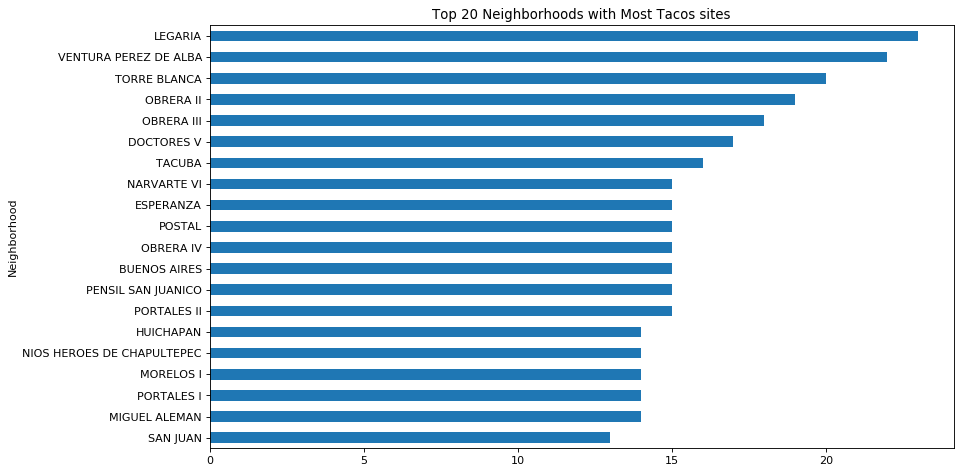

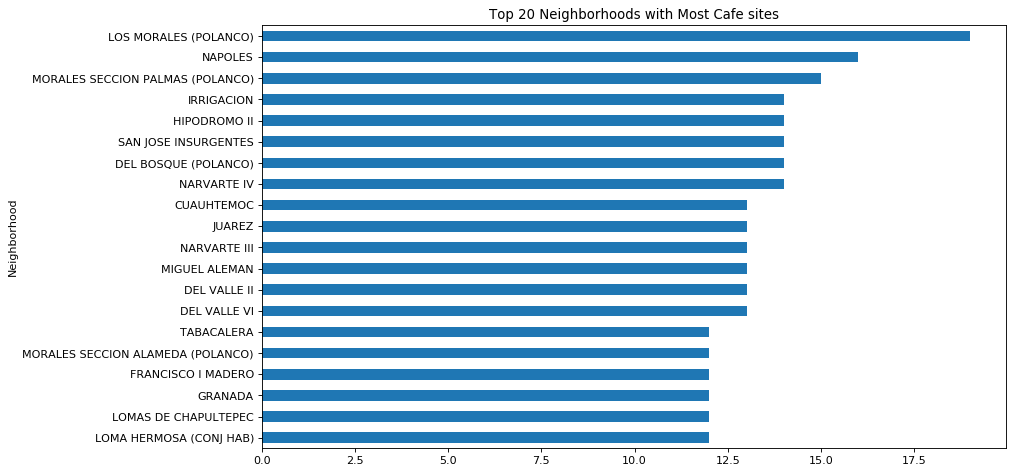

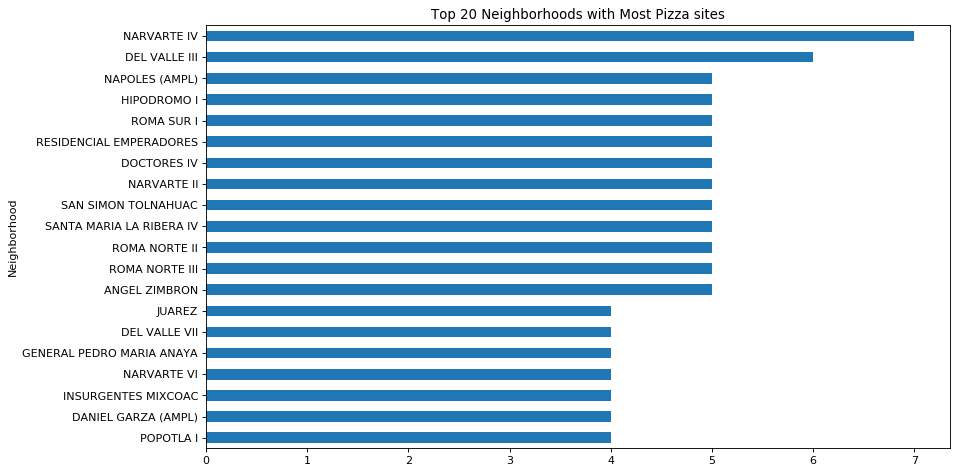

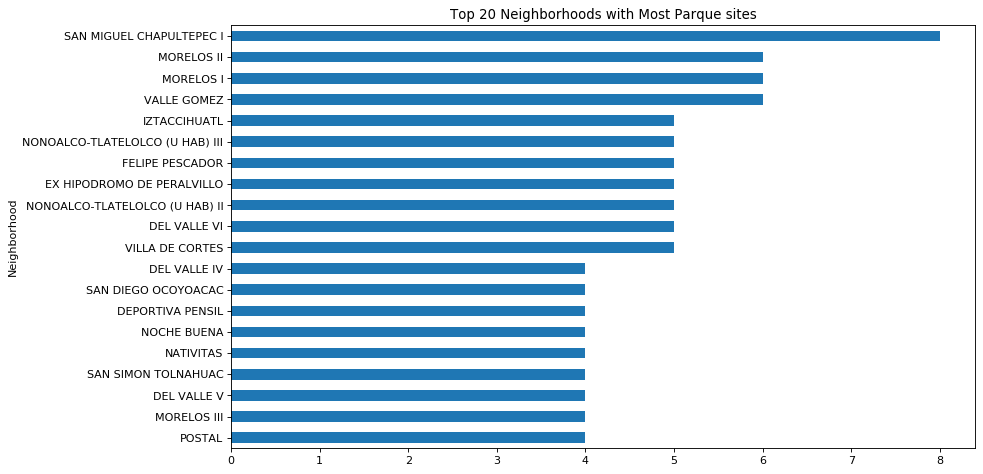

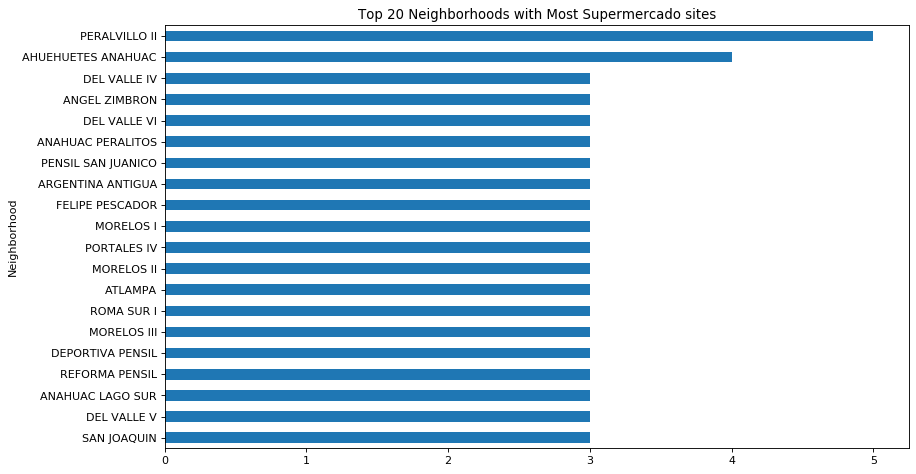

In [241]:
# Top 20 Neighborhood Plots
plot_categories = ['Tacos', 'Cafe', 'Pizza', 'Parque', 'Supermercado']
n = 20
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'Top {n} Neighborhoods with Most {category} sites')
    top_category_neighborhoods = venue_counts[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods = top_category_neighborhoods.sort_values(ascending=True)
    top_category_neighborhoods.plot.barh(y=category, rot=0)

### Add a value to the table counts to define the clusters

In [242]:
# Add a new column with interests counts value
venue_counts = venue_counts.replace(to_replace=0, value=np.nan)
venue_counts['Value'] = venue_counts.count(axis='columns') /1.9
venue_counts = venue_counts.replace(to_replace=np.nan, value=0).reset_index()
venue_counts.head(10)

,Neighborhood,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
0,10 DE ABRIL,10.0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,6.0,0.0,3.157895
1,16 DE SEPTIEMBRE,3.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,3.0,0.0,2.631579
2,5 DE MAYO,8.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,3.0,0.0,4.210526
3,ACACIAS,11.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,5.0,0.0,3.684211
4,ACTIPAN,10.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.105263
5,AGRICULTURA,6.0,0.0,0.0,0.0,2.0,4.0,0.0,2.0,9.0,0.0,2.631579
6,AHUEHUETES ANAHUAC,4.0,0.0,0.0,0.0,2.0,3.0,0.0,4.0,13.0,0.0,2.631579
7,ALAMOS I,6.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,9.0,0.0,2.631579
8,ALAMOS II,8.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,11.0,0.0,2.105263
9,ALBERT,5.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,11.0,0.0,3.157895


In [243]:
# Change the columns type to integers
venue_counts['Cafe'] = venue_counts['Cafe'].astype(int)
venue_counts['Farmacia'] = venue_counts['Farmacia'].astype(int)
venue_counts['Libreria'] = venue_counts['Libreria'].astype(int)
venue_counts['Musica'] = venue_counts['Musica'].astype(int)
venue_counts['Parque'] = venue_counts['Parque'].astype(int)
venue_counts['Pizza'] = venue_counts['Pizza'].astype(int)
venue_counts['Spa'] = venue_counts['Spa'].astype(int)
venue_counts['Supermercado'] = venue_counts['Supermercado'].astype(int)
venue_counts['Tacos'] = venue_counts['Tacos'].astype(int)
venue_counts['Yoga'] = venue_counts['Yoga'].astype(int)
venue_counts['Value'] = venue_counts['Value'].astype(int)
venue_counts.dtypes

Neighborhood    object
Cafe             int64
Farmacia         int64
Libreria         int64
Musica           int64
Parque           int64
Pizza            int64
Spa              int64
Supermercado     int64
Tacos            int64
Yoga             int64
Value            int64
dtype: object

In [244]:
#show the dataframe
venue_counts.head()

,Neighborhood,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
0,10 DE ABRIL,10,1,0,0,2,0,1,2,6,0,3
1,16 DE SEPTIEMBRE,3,2,0,0,0,2,0,1,3,0,2
2,5 DE MAYO,8,1,1,0,2,1,1,2,3,0,4
3,ACACIAS,11,1,0,1,2,2,1,0,5,0,3
4,ACTIPAN,10,0,0,0,1,1,0,0,4,0,2


In [249]:
# Get new dataframe with all the columns
clustercolonias = colonias
clustercolonias = clustercolonias.join(venue_counts.set_index('Neighborhood'), on='COLONIA').dropna(axis=0)
clustercolonias.head()

,COLONIA,ALCALDIA,Latitude,Longitude,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
0,LOMAS DE CHAPULTEPEC,MIGUEL HIDALGO,19.422841,-99.215794,12,1,1,1,1,1,3,0,6,0,4
1,LOMAS DE REFORMA,MIGUEL HIDALGO,19.401682,-99.235472,7,1,1,1,2,0,0,2,2,1,4
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),MIGUEL HIDALGO,19.410616,-99.226249,2,1,1,0,3,0,0,1,0,0,2
3,IRRIGACION,MIGUEL HIDALGO,19.442955,-99.209936,14,1,0,0,3,0,1,2,3,0,3
4,DEL BOSQUE (POLANCO),MIGUEL HIDALGO,19.434219,-99.209404,14,1,0,0,2,0,1,2,6,0,3


In [250]:
# Count Neighborhoods in Clusters 
fn_unique = len(clustercolonias['Value'].unique())
print(f'There are {fn_unique} unique venue categories in this dataframe')
clustercolonias.groupby('Value')['Value'].count()

There are 6 unique venue categories in this dataframe


Value
0     1
1     9
2    81
3    88
4    32
5     4
Name: Value, dtype: int64

# Step 6. Make a Map with the Results

In [251]:
# Make the results a dataframe to present the clusters
values = clustercolonias.groupby('Value')['Value'].count()

In [252]:
# Define Clusters
kclusters1 = fn_unique

In [168]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude = 19.4195042636
longitude = -99.1387615628
map_bests = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters1)
ys = [i + x + (i*x)**2 for i in range(kclusters1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustercolonias['Latitude'], clustercolonias['Longitude'], clustercolonias['COLONIA'], clustercolonias['Value']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_bests)
       
map_bests.save('map_bests.html')
map_bests

### Show the Neighborhoods in Cluster 5

In [253]:
# Define the Cluster as 5 and show the shape
print('This cluster have', values.loc[5],'neighborhoods')
clustercolonias.loc[clustercolonias['Value'] == 5, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 4 neighborhoods


,COLONIA,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
1221,ROMA SUR II,7,2,1,1,1,2,1,1,8,1,5
1276,NARVARTE VI,11,3,1,1,1,4,2,1,15,1,5
1559,RESIDENCIAL EMPERADORES,6,2,1,1,1,5,1,2,9,1,5
1621,ANGEL ZIMBRON,3,1,1,1,2,5,1,3,13,2,5


In [254]:
# Define a dataframe with the top results 
ncluster = [5]
clustermejorcolonia = clustercolonias[clustercolonias['Value'].isin(ncluster)]
clustermejorcolonia

,COLONIA,ALCALDIA,Latitude,Longitude,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
1221,ROMA SUR II,CUAUHTEMOC,19.404015,-99.163301,7,2,1,1,1,2,1,1,8,1,5
1276,NARVARTE VI,BENITO JUAREZ,19.386893,-99.150385,11,3,1,1,1,4,2,1,15,1,5
1559,RESIDENCIAL EMPERADORES,BENITO JUAREZ,19.368425,-99.157519,6,2,1,1,1,5,1,2,9,1,5
1621,ANGEL ZIMBRON,MIGUEL HIDALGO,19.462801,-99.189367,3,1,1,1,2,5,1,3,13,2,5


In [256]:
# create map of Mexico City using latitude and longitude values
map_mejorcolonia = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, alcaldia, colonia in zip(clustermejorcolonia['Latitude'], clustermejorcolonia['Longitude'], clustermejorcolonia['ALCALDIA'], clustermejorcolonia['COLONIA']):
    label = '{}, {}'.format(colonia, alcaldia)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mejorcolonia)  
map_mejorcolonia.save('map_mejorcolonia.html')
map_mejorcolonia

### Show the Neighborhoods in the Others Clusters

In [257]:
# Define the Cluster as 4 and show the shape
print('This cluster have', values.loc[4],'neighborhoods')
clustercolonias.loc[clustercolonias['Value'] == 4, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 32 neighborhoods


,COLONIA,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
0,LOMAS DE CHAPULTEPEC,12,1,1,1,1,1,3,0,6,0,4
1,LOMAS DE REFORMA,7,1,1,1,2,0,0,2,2,1,4
31,5 DE MAYO,8,1,1,0,2,1,1,2,3,0,4
38,PENSIL SUR,7,1,1,0,2,1,1,1,4,0,4
379,VERTIZ NARVARTE,10,2,1,1,1,2,3,2,11,0,4
811,DEL VALLE V,11,1,2,0,4,3,2,3,5,1,4
813,DEL VALLE II,13,1,1,0,1,3,3,1,4,0,4
1218,HIPODROMO I,6,0,1,1,3,5,2,0,3,2,4
1223,ROMA SUR I,5,1,1,1,1,5,1,3,4,0,4
1400,HIPODROMO II,14,1,3,0,2,1,1,0,3,2,4


In [258]:
# Define the Cluster as 3 and show the shape
print('This cluster have', values.loc[3],'neighborhoods')
clustercolonias.loc[clustercolonias['Value'] == 3, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 88 neighborhoods


,COLONIA,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
3,IRRIGACION,14,1,0,0,3,0,1,2,3,0,3
4,DEL BOSQUE (POLANCO),14,1,0,0,2,0,1,2,6,0,3
5,DANIEL GARZA (AMPL),4,0,0,1,3,4,0,0,12,2,3
8,LEGARIA (U HAB),4,2,0,0,3,0,1,1,9,0,3
32,MORALES SECCION ALAMEDA (POLANCO),12,1,0,0,0,1,2,1,1,0,3
35,TORRE BLANCA,2,1,0,1,1,1,0,3,20,0,3
350,INDEPENDENCIA,7,1,0,0,1,2,2,2,13,0,3
351,ALBERT,5,1,0,0,1,2,0,1,11,0,3
374,SAN PEDRO DE LOS PINOS,8,2,0,0,3,2,0,1,4,0,3
375,NAPOLES,16,0,0,1,1,4,2,0,3,0,3


In [259]:
# Define the Cluster as 2 and show the shape
print('This cluster have', values.loc[2],'neighborhoods')
clustercolonias.loc[clustercolonias['Value'] == 2, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 81 neighborhoods


,COLONIA,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),2,1,1,0,3,0,0,1,0,0,2
6,IGNACIO MANUEL ALTAMIRANO,0,0,1,1,3,1,0,0,11,0,2
7,LEGARIA,4,0,0,0,1,1,0,3,23,0,2
9,MARINA NACIONAL (U HAB),8,0,0,0,0,3,0,3,11,0,2
36,UN HOGAR PARA NOSOTROS,3,0,0,0,1,2,0,0,10,0,2
353,ATENOR SALAS,5,0,0,0,1,3,0,1,9,0,2
377,NATIVITAS,9,0,0,1,4,3,0,0,11,0,2
378,SAN SIMON TICUMAC,7,0,0,0,1,2,0,3,12,0,2
381,ALAMOS II,8,0,0,0,2,0,0,2,11,0,2
384,PENSIL NORTE,4,1,0,0,3,0,0,2,12,0,2


In [260]:
# Define the Cluster as 1 and show the shape
print('This cluster have', values.loc[1],'neighborhoods')
clustercolonias.loc[clustercolonias['Value'] == 1, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 9 neighborhoods


,COLONIA,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
37,PLUTARCO ELIAS CALLES,4,0,0,0,1,0,0,0,5,0,1
1004,TABACALERA,12,0,0,0,0,2,0,0,4,0,1
1405,OBRERA III,3,0,0,0,0,0,0,3,18,0,1
1406,OBRERA II,4,0,0,0,0,0,0,2,19,0,1
1493,OBRERA IV,4,0,0,0,0,0,0,1,15,0,1
1566,NONOALCO-TLATELOLCO (U HAB) I,0,0,0,2,3,0,0,0,10,0,1
1604,TACUBAYA,5,0,0,0,0,3,0,0,11,0,1
1656,"BOSQUE DE CHAPULTEPEC I, II Y III SECCIONES",7,0,0,0,3,0,0,0,2,0,1
1753,SAN LORENZO TLALTENANGO,0,0,0,0,2,0,0,0,3,0,1


In [261]:
# Define the Cluster as 0 and show the shape
print('This cluster have', values.loc[0],'neighborhoods')
clustercolonias.loc[clustercolonias['Value'] == 0, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 1 neighborhoods


,COLONIA,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga,Value
1748,MILITAR 1 K LOMAS DE SOTELO (U HAB),0,0,0,0,0,0,0,0,1,0,0


---

# Alternate Analysis - K-means Clusters

### Check the Value Means of Each Category  
(If we want to group the neighborhoods in clusters by their Top Category)

In [198]:
orig_interest = ['Cafe', 'Farmacia', 'Libreria', 'Pizza', 'Tacos', 'Parque', 'Supermercado', 'Spa', 'Yoga', 'Musica']

In [202]:
venue_counts1 = venue_category_onehot.groupby('Neighborhood').sum()
venue_counts1.head(10)

,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga
Neighborhood,,,,,,,,,,
10 DE ABRIL,10,1,0,0,2,0,1,2,6,0
16 DE SEPTIEMBRE,3,2,0,0,0,2,0,1,3,0
5 DE MAYO,8,1,1,0,2,1,1,2,3,0
ACACIAS,11,1,0,1,2,2,1,0,5,0
ACTIPAN,10,0,0,0,1,1,0,0,4,0
AGRICULTURA,6,0,0,0,2,4,0,2,9,0
AHUEHUETES ANAHUAC,4,0,0,0,2,3,0,4,13,0
ALAMOS I,6,0,0,0,2,1,0,2,9,0
ALAMOS II,8,0,0,0,2,0,0,2,11,0


In [203]:
# For each venue category, determine the percentage of entities in each neighborhood
venue_totals = {}
for category in orig_interest:
    venue_totals[category] = venue_counts1[category].sum()

venue_mean = pd.DataFrame()
for category, total in venue_totals.items():
    venue_mean[category] = venue_counts1[category].apply(lambda x: x / total)
venue_mean = venue_mean.reindex(sorted(venue_mean.columns), axis=1).reset_index()
venue_mean.head(5)

,Neighborhood,Cafe,Farmacia,Libreria,Musica,Parque,Pizza,Spa,Supermercado,Tacos,Yoga
0,10 DE ABRIL,0.006887,0.005988,0.000000,0.0000,0.005602,0.000000,0.007874,0.006579,0.003639,0.0
1,16 DE SEPTIEMBRE,0.002066,0.011976,0.000000,0.0000,0.000000,0.005155,0.000000,0.003289,0.001819,0.0
2,5 DE MAYO,0.005510,0.005988,0.011236,0.0000,0.005602,0.002577,0.007874,0.006579,0.001819,0.0
3,ACACIAS,0.007576,0.005988,0.000000,0.0125,0.005602,0.005155,0.007874,0.000000,0.003032,0.0
4,ACTIPAN,0.006887,0.000000,0.000000,0.0000,0.002801,0.002577,0.000000,0.000000,0.002426,0.0


In [204]:
def return_top_venue_categories(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [205]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Top Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Top Venue Category'.format(ind+1))
neighborhoods_top_venue_categories = pd.DataFrame(columns=columns)
neighborhoods_top_venue_categories['Neighborhood'] = venue_mean['Neighborhood']
for ind in np.arange(venue_mean.shape[0]):
    neighborhoods_top_venue_categories.iloc[ind, 1:] = return_top_venue_categories(venue_mean.iloc[ind, :], num_top_venues)
neighborhoods_top_venue_categories.head(5)

,Neighborhood,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,10 DE ABRIL,Spa,Cafe,Supermercado,Farmacia,Parque
1,16 DE SEPTIEMBRE,Farmacia,Pizza,Supermercado,Cafe,Tacos
2,5 DE MAYO,Libreria,Spa,Supermercado,Farmacia,Parque
3,ACACIAS,Musica,Spa,Cafe,Farmacia,Parque
4,ACTIPAN,Cafe,Parque,Pizza,Tacos,Yoga


### Creating a new dataframe merging neighborhood location data, top venue category by neighborhood, and cluster labels

In [207]:
# Define Clusters
kclusters = 8

venue_grouped_clustering = venue_mean.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_grouped_clustering)

kmeans.labels_

array([0, 6, 4, 5, 0, 0, 0, 0, 0, 0, 0, 6, 4, 7, 0, 0, 0, 0, 0, 0, 0, 2,
       3, 6, 5, 5, 0, 5, 0, 4, 4, 5, 0, 0, 4, 4, 4, 4, 5, 4, 6, 4, 4, 1,
       1, 7, 5, 0, 1, 4, 6, 2, 0, 7, 3, 3, 1, 1, 7, 4, 6, 4, 4, 4, 5, 0,
       3, 4, 3, 0, 0, 5, 6, 0, 5, 1, 4, 5, 0, 4, 4, 1, 2, 1, 5, 5, 3, 5,
       1, 0, 5, 5, 4, 0, 6, 7, 7, 7, 6, 7, 3, 7, 4, 7, 7, 0, 6, 0, 0, 4,
       6, 3, 0, 3, 6, 0, 5, 5, 3, 3, 0, 0, 0, 3, 7, 0, 0, 4, 7, 3, 3, 5,
       6, 3, 5, 6, 5, 5, 0, 0, 0, 0, 0, 0, 2, 6, 7, 5, 0, 0, 4, 5, 6, 7,
       3, 4, 0, 1, 4, 4, 0, 0, 3, 3, 3, 3, 0, 5, 0, 1, 7, 3, 7, 7, 0, 4,
       7, 5, 6, 0, 5, 0, 2, 2, 6, 0, 7, 0, 5, 5, 5, 5, 0, 0, 0, 4, 0, 5,
       0, 7, 5, 7, 5, 6, 0, 4, 0, 0, 0, 3, 3, 5, 5, 5, 0], dtype=int32)

In [208]:
neighborhoods_top_venue_categories.insert(1,'Cluster Labels', kmeans.labels_)

mejorescolonias = colonias.drop(columns=['ALCALDIA'])

mejorescolonias = mejorescolonias.join(neighborhoods_top_venue_categories.set_index('Neighborhood'), on='COLONIA').dropna(axis=0)

mejorescolonias.head()

,COLONIA,Latitude,Longitude,Cluster Labels,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
0,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,3,Spa,Musica,Libreria,Cafe,Farmacia
1,LOMAS DE REFORMA,19.401682,-99.235472,7,Yoga,Musica,Libreria,Supermercado,Farmacia
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.410616,-99.226249,4,Libreria,Parque,Farmacia,Supermercado,Cafe
3,IRRIGACION,19.442955,-99.209936,0,Cafe,Parque,Spa,Supermercado,Farmacia
4,DEL BOSQUE (POLANCO),19.434219,-99.209404,0,Cafe,Spa,Supermercado,Farmacia,Parque


In [209]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude = 19.4195042636
longitude = -99.1387615628
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mejorescolonias['Latitude'], mejorescolonias['Longitude'], mejorescolonias['COLONIA'], mejorescolonias['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('map_clusters.html')
map_clusters

In [263]:
mejorescolonias.loc[mejorescolonias['Cluster Labels'] == 7, mejorescolonias.columns[[0] + list(range(4, mejorescolonias.shape[1]))]]

,COLONIA,1st Top Venue Category,2nd Top Venue Category,3rd Top Venue Category,4th Top Venue Category,5th Top Venue Category
1,LOMAS DE REFORMA,Yoga,Musica,Libreria,Supermercado,Farmacia
661,ROMA NORTE II,Yoga,Pizza,Libreria,Cafe,Tacos
810,DEL VALLE I,Yoga,Spa,Cafe,Tacos,Supermercado
830,TLAXPANA,Yoga,Tacos,Farmacia,Cafe,Pizza
1216,ROMA NORTE I,Yoga,Pizza,Spa,Cafe,Parque
1221,ROMA SUR II,Yoga,Musica,Farmacia,Libreria,Spa
1233,TATA LZARO,Yoga,Parque,Supermercado,Cafe,Farmacia
1459,NARVARTE IV,Pizza,Yoga,Musica,Cafe,Spa
1496,SAN RAFAEL II,Yoga,Tacos,Cafe,Farmacia,Supermercado
1541,NAPOLES (AMPL),Yoga,Spa,Pizza,Cafe,Farmacia
